In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import time
from sklearn.preprocessing import MinMaxScaler
import keras_tuner as kt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

def custom_mre(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    relative_error = np.abs((y_true - y_pred) / y_true)
    mre = np.mean(relative_error) * 100.0
    return mre

Using TensorFlow backend


In [2]:
# Cargar el archivo CSV con punto y coma como delimitador
data = pd.read_csv('Cluster0ReadyToNN.csv', delimiter=';')

# Crear un diccionario para almacenar los objetos scaler por grupo
scalers = {}

# Iterar sobre los grupos únicos en Column15
for group in data['Column15'].unique():
    # Filtrar datos por grupo
    group_data = data[data['Column15'] == group]

    # Seleccionar las columnas para normalización (las 13 primeras)
    features = group_data.iloc[:, :13]

    # Normalizar los datos con MinMaxScaler
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(features)

    # Almacenar el scaler en el diccionario
    scalers[group] = scaler

    # Actualizar el DataFrame con los datos normalizados
    data.loc[data['Column15'] == group, 'Column1':'Column13'] = normalized_data

# Guardar el DataFrame modificado en un nuevo archivo CSV con punto y coma como delimitador
#data.to_csv('DataNormalized.csv', index=False, sep=';')


In [3]:
# Ordenar el DataFrame por 'Column 14' de forma ascendente
data = data.sort_values(by='Column14')

# Dividir los datos en entrenamiento (70%) y temporal (30%)
train_temp_data, test_data = train_test_split(data, test_size=0.3, stratify=data['Column15'], random_state=0)
#train_temp_data, test_data = train_test_split(data, test_size=0.3, shuffle=False, random_state=0)

# Dividir el temporal en entrenamiento (70%) y validación (30%)
train_data, validation_data = train_test_split(train_temp_data, test_size=0.3, stratify=train_temp_data['Column15'], random_state=0)
#train_data, validation_data = train_test_split(train_temp_data, test_size=0.3, shuffle=False, random_state=0)

# Separar características (X) y columna objetivo (y)
X_train_norm = train_data.iloc[:, :12]
y_train_norm = train_data['Column13']
X_val_norm = validation_data.iloc[:, :12]
y_val_norm = validation_data['Column13']
X_test_norm = test_data.iloc[:, :12]
y_test_norm = test_data['Column13']

In [4]:
data

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9,Column10,Column11,Column12,Column13,Column14,Column15
0,0.317757,0.163551,1.000000,0.957447,1.000000,0.750000,0.979167,0.708333,0.979167,1.000000,0.641026,0.897436,1.000000,2002/3,23
30078,0.164179,0.194030,0.138686,0.138686,0.109489,0.167883,0.160584,0.160584,0.160584,0.182482,0.153285,0.145985,0.167883,2002/3,10755
139428,0.042553,0.652482,0.836879,1.000000,0.295775,0.816901,0.295775,0.281690,0.492958,0.985915,0.436620,0.281690,0.535211,2002/3,49541
30024,0.203822,0.286624,0.159236,0.197452,0.178344,0.197452,0.140127,0.159236,0.210191,0.267516,0.248408,0.394904,1.000000,2002/3,10617
139482,0.000000,0.032000,0.016000,0.024000,0.032000,0.104000,0.352000,0.120000,0.048000,1.000000,0.825688,0.609091,0.054545,2002/3,49567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102221,0.047619,0.081633,0.156463,0.183673,0.115646,0.081633,0.299320,0.115646,0.095238,0.129252,0.129252,0.653061,0.319728,2015/4,35402
65879,0.119403,0.031716,0.041045,0.145522,0.078358,0.022388,0.024254,0.095149,0.067164,0.011194,0.035448,0.177239,0.082090,2015/4,22419
135863,0.091139,0.126582,0.162025,0.048101,0.106329,0.189873,0.164557,0.111392,0.098734,0.116456,0.147959,0.107143,0.087629,2015/4,47934
135755,0.028777,0.028777,0.050360,0.035971,0.035971,0.035971,0.043165,0.029197,0.000000,0.007299,0.021898,0.051095,0.007299,2015/4,47798


In [5]:
test_data.head(20)

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9,Column10,Column11,Column12,Column13,Column14,Column15
24905,0.222222,0.277778,0.265306,0.224490,0.367347,0.251701,1.000000,0.312925,0.292517,0.170068,0.209459,0.216216,0.128378,2005/2,8751
155320,0.228972,0.084112,0.049065,0.058411,0.144860,0.067757,0.058411,0.260870,0.335404,0.198758,0.149068,0.186335,0.347826,2006/3,56704
8745,0.114943,0.114943,0.103448,0.126437,0.126437,0.159420,0.150000,0.150000,0.083333,0.116667,0.103448,0.155172,0.051724,2015/2,3059
60462,0.307241,0.054264,0.032946,0.108527,0.300388,0.054264,0.031008,0.040698,0.253876,0.036320,0.019370,0.053269,0.295400,2011/3,20496
4241,0.162963,0.118519,0.177778,0.133333,0.118519,0.140741,0.140741,0.074074,0.103704,0.111111,0.918519,0.096296,0.155556,2009/4,1242
58407,0.142132,0.157360,0.182741,0.096447,0.131980,0.147208,0.131980,0.131980,0.126904,0.147208,0.126904,0.096939,0.091837,2010/4,19892
124215,0.038462,0.102564,0.166667,0.128205,0.128205,0.192308,0.179487,0.076923,0.051282,0.064103,0.128205,0.025641,0.012821,2006/2,43198
143532,0.000000,0.046154,0.015385,0.092308,0.061538,0.076923,0.000000,0.031250,0.062500,0.000000,0.000000,0.046875,0.062500,2002/3,51327
34430,0.080103,0.069767,0.056848,0.056848,0.095607,0.082687,0.058974,0.053846,0.105128,0.133333,0.074359,0.056410,0.061538,2010/3,12261
75228,0.209877,0.152263,0.259259,0.152091,0.190114,0.129278,0.045627,0.007605,0.019011,0.030418,0.326996,0.075269,0.046595,2004/1,25336


In [4]:
# Cargar el modelo preentrenado
model = load_model('modelTrainedv2.h5', custom_objects={'custom_mre': custom_mre})

# Definir una función para construir el modelo con un learning rate ajustable
def build_model(hp):
    # Crear una nueva capa de entrada con 12 neuronas
    nueva_capa_entrada = Input(shape=(12,))
    
    # Construir un nuevo modelo que incluya la nueva capa de entrada
    new_model = Sequential()
    new_model.add(nueva_capa_entrada)

    # Redimensionar la capa dense_1 para que sea compatible con 12 neuronas de entrada
    new_model.add(Dense(30, activation='tanh', input_shape=(12,), name="Input"))

    # Congelar las primeras 12 capas
    numFreezeLayers = 12

    # Agregar las capas restantes del modelo preentrenado (excluyendo la capa de entrada original)
    for layer in model.layers[1:numFreezeLayers]:
        new_model.add(layer)
   
    for capa in new_model.layers[0:numFreezeLayers+1]:
        capa.trainable = False

    # Agregar las capas del modelo preentrenado (excluyendo la capa de entrada original)
    for i, layer in enumerate(model.layers[numFreezeLayers:]):  # Excluir la capa de entrada
        # Solo modificar capas entrenables (trainable=True)
        if isinstance(layer, Dense):  # Solo modificar capas Dense
            if layer.trainable:
                # Ajustamos el número de neuronas solo en las capas entrenables
                dense_units = hp.Int(f'HL_{numFreezeLayers+i}_units', min_value=20, max_value=100, step=10)  # Neuronas ajustables
                new_model.add(Dense(dense_units, activation=layer.activation, name=f"dense_tunable_{numFreezeLayers+i}"))
            else:
                # Si la capa no es entrenable, agregamos la capa tal cual está
                new_model.add(layer)
        else:
            # Si no es una capa Dense (por ejemplo, Dropout, Flatten, etc.), la agregamos tal cual
            new_model.add(layer)

    # Agregar una nueva capa de salida con 1 neurona
    new_model.add(Dense(1, activation='tanh', name='Output'))

    # Definir el optimizador con un learning rate ajustable
    optimizer = Adam(
        learning_rate=hp.Float('learning_rate', min_value=0.00001, max_value=0.001, sampling='log')
    )

    # Compilar el modelo
    new_model.compile(
        optimizer=optimizer,
        loss='mean_absolute_error',
        metrics=['mean_absolute_error','mean_squared_error']
    )
    # Obtener las funciones de activación asignadas
    activations = [layer.activation.__name__ for layer in new_model.layers]
    print(activations)

    # Obtener funciones de activación y entrenabilidad asignadas
    layer_info = [layer.trainable for layer in new_model.layers]
    print(layer_info)

    new_model.summary()

    return new_model

In [5]:
start_time = time.time()
# Configurar el tuner para la optimización bayesiana
tuner = kt.BayesianOptimization(
    build_model,
    objective=kt.Objective("val_mean_absolute_error",direction="min"),
    #objective='val_loss',
    max_trials=50,  # Número máximo de configuraciones a probar
    directory='bayesian_optimization',
    project_name='transfer_learning_elec-water_12freeze',
    overwrite=False,
)

# Ejecutar la búsqueda de hiperparámetros
tuner.search(
    X_train_norm, y_train_norm,
    validation_data=(X_val_norm, y_val_norm),
    epochs=100,  # Número máximo de épocas
    batch_size=256,
    callbacks=[keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        min_delta=1E-4,
        restore_best_weights=True
    )]
)
end_time = time.time()

optimization_time = end_time - start_time
# Imprime el tiempo de entrenamiento en segundos y en formato de horas, minutos y segundos
print(f'Tiempo de optimizacion (HH:MM:SS): {int(optimization_time // 3600)}:{int((optimization_time % 3600) // 60)}:{int(optimization_time % 60)}')

Trial 50 Complete [00h 01m 40s]
val_mean_absolute_error: 0.0906044989824295

Best val_mean_absolute_error So Far: 0.08915232121944427
Total elapsed time: 01h 58m 14s
Tiempo de optimizacion (HH:MM:SS): 1:58:14


In [4]:
# Entrenar el modelo con Early Stopping
num_epochs = 300
batch_size = 256

# Obtener el mejor learning rate
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_lr = best_hps.get('learning_rate')
print(f"Mejor tasa de aprendizaje encontrada: {best_lr}")

# Comienza a medir el tiempo de entrenamiento
start_time = time.time()
# Entrenar el mejor modelo con el learning rate óptimo
best_model = tuner.get_best_models(num_models=1)[0]
history = best_model.fit(
    X_train_norm, y_train_norm,
    validation_data=(X_val_norm, y_val_norm),
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=[keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        min_delta=1E-4,
        restore_best_weights=True
    )]
)
# Finaliza la medición del tiempo de entrenamiento
end_time = time.time()

# Resumen del modelo final
best_model.summary()

training_time = end_time - start_time
# Imprime el tiempo de entrenamiento en segundos y en formato de horas, minutos y segundos
print(f'Tiempo de entrenamiento: {training_time:.2f} segundos')


NameError: name 'tuner' is not defined

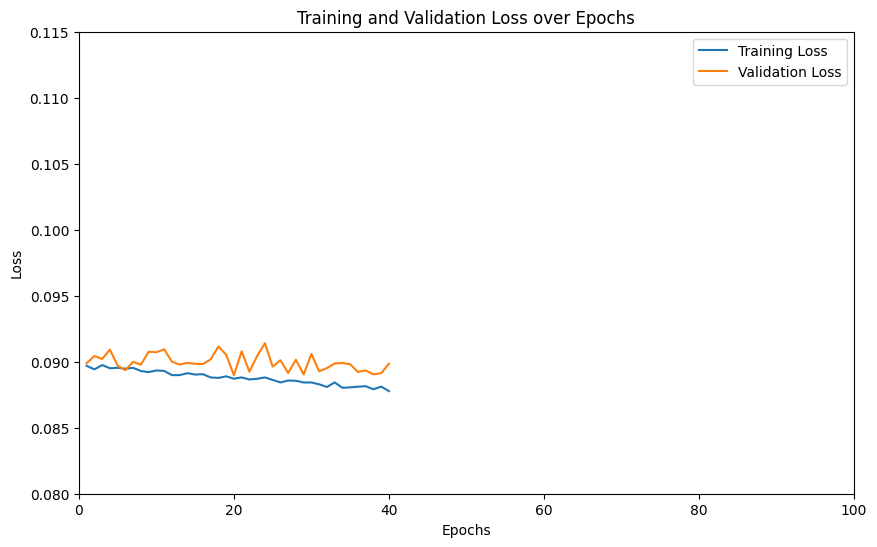

Tiempo total de entrenamiento: 79.8690242767334 segundos


In [7]:
import matplotlib.pyplot as plt

# Extraer la información de la función objetivo desde el historial de entrenamiento
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear un gráfico con los valores de la función objetivo respecto a las épocas
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')

# Ajustar los límites de los ejes
plt.ylim(0.080, 0.115)
plt.xlim(0, 100)

# Agregar etiquetas y leyenda al gráfico
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Mostrar el gráfico
plt.show()

# Imprimir el tiempo total de entrenamiento
print(f"Tiempo total de entrenamiento: {end_time - start_time} segundos")

In [8]:
# Realizar predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test_norm)
print(y_pred)

# Crear un DataFrame con las predicciones desnormalizadas y los valores reales
resultados = pd.DataFrame({'Valor Real': y_test_norm.values.flatten(), 'Predicciones': y_pred.flatten()})
print(resultados)

# Agregar la columna de predicciones al conjunto de prueba
test_data['Predicted_Column13'] = y_pred.flatten()

# Crear un DataFrame para almacenar los resultados desnormalizados
desnormalized_test_data = test_data.copy()

# Desnormalizar 'Column1' a 'Column13' y 'Predicted_Column13' según la normalización por grupos
for group, scalerY in scalers.items():
    # Filtrar el conjunto de prueba correspondiente al grupo
    group_test_data = test_data[test_data['Column15'] == group]

    # Seleccionar las columnas normalizadas para desnormalizar
    normalized_features = group_test_data[['Column1', 'Column2', 'Column3', 'Column4', 'Column5', 'Column6', 'Column7', 'Column8', 'Column9', 'Column10', 'Column11', 'Column13', 'Predicted_Column13']]

    # Desnormalizar los datos utilizando el objeto scalerY correspondiente
    original_data = scalerY.inverse_transform(normalized_features)

    # Crear un DataFrame temporal para almacenar los datos desnormalizados
    temp_df = pd.DataFrame(original_data, columns=['Column1', 'Column2', 'Column3', 'Column4', 'Column5', 'Column6', 'Column7', 'Column8', 'Column9', 'Column10', 'Column11', 'Column13', 'Predicted_Column13'])

    # Actualizar el DataFrame desnormalizado con los datos desnormalizados
    desnormalized_test_data.loc[desnormalized_test_data['Column15'] == group, ['Column1', 'Column2', 'Column3', 'Column4', 'Column5', 'Column6', 'Column7', 'Column8', 'Column9', 'Column10', 'Column11', 'Column13', 'Predicted_Column13']] = temp_df.values

# Imprimir el conjunto de prueba después de la desnormalización
print(desnormalized_test_data)

# Eliminar todas las columnas excepto las últimas cuatro
resultados = desnormalized_test_data.iloc[:, -4:]

# Imprimir el conjunto de prueba después de la eliminación de columnas
print(resultados)

1600/1600 [==============================] - 3s 2ms/step
[[0.17326167]
 [0.22091205]
 [0.11876182]
 ...
 [0.09520266]
 [0.2540386 ]
 [0.37169853]]
       Valor Real  Predicciones
0        0.128378      0.173262
1        0.347826      0.220912
2        0.051724      0.118762
3        0.295400      0.271600
4        0.155556      0.092830
...           ...           ...
51171    0.321429      0.142536
51172    0.011936      0.056838
51173    0.053030      0.095203
51174    0.312155      0.254039
51175    0.600000      0.371699

[51176 rows x 2 columns]


C:\Users\AdrianGilGamboa\AppData\Local\Temp\ipykernel_12216\3725175599.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[19.05006427 18.99920824 23.96164794 20.47885877 18.29252395 16.46602412
 20.76643793 18.72107559 38.83599472 22.96659994 36.65354776 19.57814053
 39.95008278 17.04069109 17.35521651 21.18140414 24.66561073]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  desnormalized_test_data.loc[desnormalized_test_data['Column15'] == group, ['Column1', 'Column2', 'Column3', 'Column4', 'Column5', 'Column6', 'Column7', 'Column8', 'Column9', 'Column10', 'Column11', 'Column13', 'Predicted_Column13']] = temp_df.values


        Column1  Column2  Column3  Column4  Column5  Column6  Column7  \
24905      58.0     66.0     62.0     56.0     77.0     60.0    170.0   
155320    101.0     39.0     24.0     28.0     65.0     32.0     28.0   
8745       30.0     30.0     29.0     31.0     31.0     31.0     29.0   
60462     193.0     59.0     48.0     87.0    186.0     59.0     47.0   
4241       35.0     29.0     37.0     31.0     29.0     32.0     32.0   
...         ...      ...      ...      ...      ...      ...      ...   
132964     37.0     35.0     33.0     35.0     34.0     36.0     21.0   
130033      5.0      8.0      7.0     11.0      1.0      7.0      8.0   
124375    137.0    120.0     63.0     60.0     54.0     73.0      6.0   
50855     185.0     32.0     49.0     67.0     51.0     37.0     56.0   
5442       29.0     65.0     44.0     31.0     50.0     69.0     48.0   

        Column8  Column9  Column10  Column11  Column12  Column13 Column14  \
24905      69.0     66.0      48.0      53.0  

In [9]:
# Obtener y_test_norm de la primera columna de resultados
y_test_norm = resultados['Column13']

# Obtener y_pred de la última columna del conjunto de prueba después de la desnormalización
y_pred = desnormalized_test_data['Predicted_Column13']

# Imprimir y_test_norm y y_pred
print("y_test_norm:", y_test_norm)
print("y_pred:", y_pred)


# Imprimir el DataFrame
print(resultados)
# Guardar el DataFrame resultados en un archivo CSV
resultados.to_csv('resultadosBayesianOpt12Freeze.csv', index=False)

# Calcular RMSE con datos desnormalizados
rmse = np.sqrt(mean_squared_error(y_test_norm, y_pred))
print(f'RMSE en el conjunto de prueba: {rmse}')

# Calcular MAE con datos desnormalizados
mae = mean_absolute_error(y_test_norm, y_pred)
print(f'MAE en el conjunto de prueba: {mae}')

# Calcular MRE con datos desnormalizados
mre = custom_mre(y_test_norm, y_pred)
print(f'MAPE en el conjunto de prueba: {mre}')

#Calcular MAPE con datos desnormalizados
#print("Mean absolute percentage error (MAPE): %f" % mean_absolute_percentage_error(y_test_norm, y_pred))

# Calcula la duración del entrenamiento en segundos
training_duration = end_time - start_time
# Imprime el tiempo de entrenamiento en segundos y en formato de horas, minutos y segundos
print(f'Tiempo de entrenamiento: {training_duration:.2f} segundos')
#print(f'Tiempo de entrenamiento (HH:MM:SS): {int(training_duration // 3600)}:{int((training_duration % 3600) // 60)}:{int(training_duration % 60)}')

y_test_norm: 24905      41.0
155320     59.0
8745       23.0
60462     150.0
4241       34.0
          ...  
132964     65.5
130033     10.0
124375     13.0
50855     145.0
5442       85.0
Name: Column13, Length: 51176, dtype: float64
y_pred: 24905      47.642727
155320     38.566841
8745       26.888185
60462     140.170619
4241       25.532101
             ...    
132964     19.990995
130033     43.855831
124375     18.566751
50855     123.961974
5442       59.886838
Name: Predicted_Column13, Length: 51176, dtype: float64
        Column13 Column14  Column15  Predicted_Column13
24905       41.0   2005/2      8751           47.642727
155320      59.0   2006/3     56704           38.566841
8745        23.0   2015/2      3059           26.888185
60462      150.0   2011/3     20496          140.170619
4241        34.0   2009/4      1242           25.532101
...          ...      ...       ...                 ...
132964      65.5   2006/3     46569           19.990995
130033      10.0   200

In [ ]:
#MAPE by year calculated in KNIME